# 0. Basics

## 0.0. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import pandas as pd
from datetime import datetime as DT

In [2]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C
import WS_Mdl.geo as G

In [3]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)

<module 'WS_Mdl.utils_imod' from 'C:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\WS_Mdl\\utils_imod.py'>

In [4]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiLineString, box

In [5]:
sfr.__version__

'0.12.1'

In [6]:
from WS_Mdl.utils import bold, style_reset

In [7]:
from imod import msw
from imod import mf6
import primod

In [8]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

## 0.1. Options

In [9]:
Pa_GPkg_1ry = r'C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\WBD_SW_NW_1ry.gpkg' 
Pa_GPkg = r"C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\acceptatiedatabase.gdb"
detailed = 'hydroobject'
primary = 'LEGGER_VASTGESTELD_WATERLOOP_CATEGORIE_A'

In [10]:
MdlN = 'NBr33'

In [11]:
U.set_verbose(False)

In [12]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax = [float(i) for i in d_INI['WINDOW'].split(',')]
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

# 1. Load Model Ins

## 1.0. Load PRJ

In [13]:
PRJ_, PRJ_OBS = UIM.o_PRJ_with_OBS(Pa_PRJ)

In [14]:
PRJ, period_data = PRJ_[0], PRJ_[1]

## 1.1. Load DIS and limit to Mdl Aa

In [15]:
PRJ_regrid = UIM.regrid_PRJ(PRJ, MdlN)

In [16]:
BND = PRJ_regrid['bnd']['ibound']

In [17]:
# Set outer boundaries to -1 (for CHD)

# Get the coordinate indices for boundaries
y_coords = BND.y
x_coords = BND.x
first_y = y_coords.isel(y=0)  # First y coordinate
last_y = y_coords.isel(y=-1)  # Last y coordinate  
first_x = x_coords.isel(x=0)  # First x coordinate
last_x = x_coords.isel(x=-1)  # Last x coordinate

# Set boundary values using .loc indexing
BND.loc[:, first_y, :] = -1  # Top row (all layers, first y, all x)
BND.loc[:, last_y, :] = -1   # Bottom row (all layers, last y, all x)
BND.loc[:, :, first_x] = -1  # Left column (all layers, all y, first x)  
BND.loc[:, :, last_x] = -1   # Right column (all layers, all y, last x)

print("✅ Boundary conditions set successfully!")

✅ Boundary conditions set successfully!


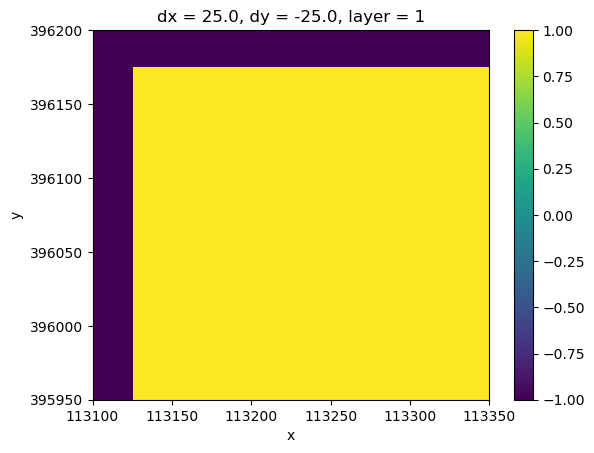

In [18]:
BND.isel(layer=0, x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

## 1.2. Load MF6 Mdl

In [19]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

Using original PRJ to load MF6 Mdl gives warnings (and it's very slow). Thus, well use the regridded PRJ, which is much faster. It can be further sped up by multi-processing, but this is not implemented yet.

In [20]:
Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_regrid, period_data, times)

In [21]:
MF6_Mdl = Sim_MF6['imported_model']

In [22]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
Sim_MF6["ims"] = UIM.mf6_solution_moderate_settings() # Mimic iMOD5's "Moderate" settings

In [23]:
MF6_DIS = MF6_Mdl["dis"]  # This gets the OLD 100m grid

## 1.3. Load MSW

### 1.3.0. Fix mete_grid.inp relative paths

In [24]:
# Replace the mete_grid.inp path in the PRJ_MSW_for_MSW dictionary
PRJ['extra']['paths'][2][0] = UIM.mete_grid_Cvt_to_AbsPa(Pa_PRJ, PRJ_regrid)

Created corrected mete_grid.inp: C:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\models\NBr\In\CAP\mete_grid\NBr5\temp\mete_grid.inp


### 1.3.1. Finally load MSW Sim

In [25]:
# Create the MetaSwap model
PRJ_MSW = {'cap': PRJ_regrid.copy()['cap'], 'extra': PRJ_regrid.copy()['extra']}
MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
print("🟢 - MetaSwap model loaded successfully!")

🟢 - MetaSwap model loaded successfully!


## 1.4. Connect MF6 to MetaSWAP

### 1.4.1. Clip models

In [26]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [27]:
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [28]:
print(f"MF6 Model AoI DIS shape: {MF6_Mdl_AoI['dis'].dataset.sizes}")
print(f"MSW Model AoI grid shape: {MSW_Mdl_AoI['grid'].dataset.sizes}")
print("✅ Both models successfully clipped to Area of Interest with compatible discretization!")

MF6 Model AoI DIS shape: Frozen({'layer': 37, 'y': 344, 'x': 480})
MSW Model AoI grid shape: Frozen({'x': 480, 'y': 344, 'subunit': 2})
✅ Both models successfully clipped to Area of Interest with compatible discretization!


## 1.5. Load & Cleanup models

### 1.5.0. Load

In [29]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

### 1.5.1. MF6 mask

In [30]:
# Create mask from current regridded model (not the old one)
mask = MF6_Mdl_AoI.domain

In [31]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

### 1.5.2. Cleanup MF6

In [32]:
try:
    for Pkg in [i for i in MF6_Mdl_AoI.keys() if ('riv' in i.lower()) or ('drn' in i.lower())]:
        MF6_Mdl_AoI[Pkg].cleanup(DIS_AoI)
except:
    print('Failed to cleanup packages. Proceeding without cleanup. Fingers crossed!')

### 1.5.3 Cleanup MetaSWAP

In [33]:
MSW_Mdl_AoI["grid"].dataset["rootzone_depth"] = MSW_Mdl_AoI["grid"].dataset["rootzone_depth"].fillna(1.0)

## 1.6. Couple & Write

In [34]:
metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(MSW_Mdl_AoI, Sim_MF6_AoI, coupling_list=[metamod_coupling])

In [35]:
os.makedirs(d_Pa['Pa_MdlN'], exist_ok=True) # Create simulation directory if it doesn't exist

In [36]:
# Use correct paths from d_Pa instead of hardcoded paths
Pa_MF6_DLL = d_Pa['MF6_DLL']
Pa_MSW_DLL = d_Pa['MSW_DLL']
Pa_IMC = d_Pa['coupler_Exe']

print(f"✅ MF6 DLL path: {Pa_MF6_DLL}")
print(f"✅ MSW DLL path: {Pa_MSW_DLL}")
print(f"✅ Coupler exe path: {d_Pa['coupler_Exe']}")

✅ MF6 DLL path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4\./modflow6/libmf6.dll
✅ MSW DLL path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4\./metaswap/MetaSWAP.dll
✅ Coupler exe path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4/imodc.exe


In [37]:
metamod.write(directory=d_Pa['Pa_MdlN'], modflow6_dll=Pa_MF6_DLL, metaswap_dll=Pa_MSW_DLL, metaswap_dll_dependency=PDN(Pa_MF6_DLL))

# 2. Create SFR

## 2.1.Load shapefile

In [38]:
GDF_all = gpd.read_file(Pa_GPkg_1ry)

In [39]:
GDF_all

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


## 2.2. Calculate routing

### 2.2.0 Extract coordinates and identify downstream segments.

#### Create Xend and Yend columns

In [40]:
GDF_all['Xstart'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[0][0]) # Access X coorddinate of first point in first linestring
GDF_all['Ystart'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[0][1])
GDF_all['Xend'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[-1][0])
GDF_all['Yend'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[-1][1])

In [41]:
print("✓ Start and end coordinates extracted.")
l_coord_cols = ['CODE', 'Xstart', 'Ystart', 'Xend', 'Yend']
GDF_all[l_coord_cols].head()

✓ Start and end coordinates extracted.


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Limit X, Y to model area

In [42]:
GDF = GDF_all[  ( (GDF_all['Xstart'].between(Xmin, Xmax, inclusive='both') | GDF_all['Xend'].between(Xmin, Xmax, inclusive='both') ) &
              (GDF_all['Ystart'].between(Ymin, Ymax, inclusive='both') | GDF_all['Yend'].between(Ymin, Ymax, inclusive='both') ) ) ]

In [43]:
# Create a lookup dictionary from start coordinates to CODE
coord_to_id = {(row.Xstart, row.Ystart): (row.CODE, row.OBJECTID) for row in GDF.itertuples()}

print(f"✓ Lookup dictionary created with {bold}{len(coord_to_id)}{style_reset} entries.")

✓ Lookup dictionary created with 583 entries.


The number of features selected in QGIS (within model area) is 562, which suprisingly is bigger than 556. We'll continue without investigating further for now.

#### Identify downstream

In [44]:
# Function to find the downstream ID
def get_DStr(row):
    end_coords = (row.Xend, row.Yend)
    result = coord_to_id.get(end_coords, (0, 0))
    return result

# Apply the function to create the 'DStr' column
GDF[['DStr_code', 'DStr_ID']] = GDF.apply(get_DStr, axis=1, result_type='expand')

print("✓ 'DStr' columns calculated.")

✓ 'DStr' columns calculated.


In [45]:
print(f'{round(GDF['DStr_code'].value_counts().max()/GDF.shape[0]*100, 2)} % of DStrs are 0 (i.e. no start coordinates match the end coordinates of the current node).')

9.48 % of DStrs are 0 (i.e. no start coordinates match the end coordinates of the current node).


The percentage is bigger than expected. Let's investigate.

### 2.2.1 Investigate segments that failed to connect

#### Check out number of matches/no matches

In [46]:
GDF['DStr_match'] = GDF['DStr_code'].isin(GDF['CODE'])
GDF['DStr_code'].value_counts()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


It makes sense that most nodes have just a few upstream nodes. 56 nodes are not connected.

In [47]:
GDF['DStr_match'].value_counts()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Calculate min distance from start to any reach's end and investigate no matches.

In [48]:
GDF['min_Dist'] = 0.0
GDF.loc[GDF['DStr_code'] == 0, 'min_Dist'] = GDF.loc[GDF['DStr_code'] == 0].apply(lambda row: C.c_Dist(row['Xend'], row['Yend'], GDF['Xstart'], GDF['Ystart']).min(), axis=1)

In [49]:
N_total_no_match = (GDF['DStr_code'] == 0).sum()

In [50]:
GDF.loc[GDF['DStr_match']==False,'min_Dist'].describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [51]:
l_Vals = [0.001, 0.1, 1, 10, 100, 1000, 10000]

print(f'Out of the {N_total_no_match} segments that do not match:')

N_below_Prv, Val_Prv = 0, 0
for v in l_Vals:
    N_below = (GDF.loc[GDF['DStr_match']==False,'min_Dist'] <= v).sum()
    P_below = round(N_below / N_total_no_match * 100, 2)
    
    sample_gdf = GDF.loc[(GDF['min_Dist'] > Val_Prv) & (GDF['min_Dist'] <= v), ['CODE', 'min_Dist']].sort_values(by='min_Dist')
    sample_gdf['Code:min_Dist'] = sample_gdf.apply(lambda row: f"{row['CODE']}: {row['min_Dist']:8.4f}", axis=1)
    sample_gdf = sample_gdf['Code:min_Dist']
    example_nodes = sample_gdf.iloc[:].tolist()

    print(f'-{Val_Prv:6} < min_Dist <= {v:5} |N: {N_below:6} (+ {(N_below - N_below_Prv):4}) ({round(P_below,1):5} %) | Codes: {example_nodes}\n')

    N_below_Prv, Val_Prv = N_below, v

Out of the 56 segments that do not match:
-     0 < min_Dist <= 0.001 |N:     37 (+   37) ( 66.1 %) | Codes: ['OVK02919:   0.0001', 'OVK02936:   0.0001', 'OVK02055:   0.0001', 'OVK02089:   0.0001', 'OVK01666:   0.0001', 'OVK20480:   0.0001', 'OVK20466:   0.0001', 'OVK02235:   0.0001', 'OVK00961:   0.0001', 'OVK20990:   0.0001', 'OVK01440:   0.0001', 'OVK00937:   0.0001', 'OVK01445:   0.0001', 'OVK00976:   0.0001', 'OVK01793:   0.0001', 'OVK01694:   0.0001', 'OVK02909:   0.0001', 'OVK00907:   0.0001', 'OVK01716:   0.0001', 'OVK01492:   0.0001', 'OVK02214:   0.0001', 'OVK00960:   0.0001', 'OVK00965:   0.0001', 'OVK01537:   0.0001', 'OVK02101:   0.0001', 'OVK01675:   0.0001', 'OVK02326:   0.0001', 'OVK01803:   0.0002', 'OVK20449:   0.0003', 'OVK02098:   0.0003', 'OVK22007:   0.0003', 'OVK01674:   0.0004', 'OVK00975:   0.0005', 'OVK01717:   0.0006', 'OVK11693:   0.0006', 'OVK00974:   0.0006', 'OVK11686:   0.0010']

- 0.001 < min_Dist <=   0.1 |N:     41 (+    4) ( 73.2 %) | Codes: ['OVK021

The total number of segments that do not match is too high to check them all, but we'll check some cases. Check C:\OD\WS_Mdl\Mng\Mdl_Ipvs.xlsx/WBD_SHP_Eval for more info.

The ones <1m can be attributed to closing errors, and we can connect them to the closest one via an algorithm.<br>Let's print out the names of the bigger differences, so that we can check them in QGIS.

In [52]:
GDF.loc[GDF['min_Dist'].between(10,100, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


- **OVK11551**: -- TO BE CORRECTED -- is an anomaly, as it attaches to a very long feature, far from the final start and end.
- **OVK02333**: -- IGNORE -- ends outside the model, so there is no feature to connect to.
- **OVK02830** & **OVK02160**: -- IGNORE -- are in the same spot. one of them is straight, the other one circles around, and they both end outside the model.
- **OVK01792**: -- IGNORE -- also ends outside the model.

In [53]:
GDF.loc[GDF['min_Dist'].between(100,1000, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


- **OVK02242**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02238**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02121**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK01807**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK03078**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02887**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek (final Mark outled outside MdlAa) 
- **OVK02933**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK01682**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK00416**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 


### 2.2.2 Edit connections

In [54]:
# Initialize the 'multiple_close' column with empty strings
GDF['multiple_close'] = ""

# Select rows to correct
rows_to_correct = GDF[(GDF['DStr_code'] == 0) & (GDF['min_Dist'] < 1)].copy()

print(f"Found {len(rows_to_correct)} segments with no downstream connection and a potential connection within 1m.")

# Create a Series of all start coordinates for faster access
all_starts_x = GDF['Xstart']
all_starts_y = GDF['Ystart']
all_codes = GDF['CODE']
all_object_ids = GDF['OBJECTID']

corrected_count = 0
multiple_count = 0

# Loop through the rows that need correction
for index, row in rows_to_correct.iterrows():
    # Calculate distances from the current row's end point to all other rows' start points
    distances = C.c_Dist(row['Xend'], row['Yend'], all_starts_x, all_starts_y)
    
    # Find segments where the distance is less than 1m
    close_mask = (distances < 1) & (GDF.index != index) # Exclude self
    close_segments_codes = all_codes[close_mask].tolist()
    close_segments_object_ids = all_object_ids[close_mask].tolist()
    
    if len(close_segments_codes) == 1:
        # If there is exactly one close segment, update both 'DStr_code' and 'DStr_ID'
        GDF.loc[index, 'DStr_code'] = close_segments_codes[0]
        GDF.loc[index, 'DStr_ID'] = close_segments_object_ids[0]
        corrected_count += 1
    elif len(close_segments_codes) > 1:
        # If there are multiple close segments, store as comma-separated string
        GDF.loc[index, 'multiple_close'] = ", ".join(close_segments_codes)
        multiple_count += 1

print(f"✓ Corrected {corrected_count} segments by updating 'DStr_code' and 'DStr_ID'.")
print(f"✓ Found {multiple_count} segments with multiple potential connections (stored in 'multiple_close').")

Found 42 segments with no downstream connection and a potential connection within 1m.
✓ Corrected 41 segments by updating 'DStr_code' and 'DStr_ID'.
✓ Found 1 segments with multiple potential connections (stored in 'multiple_close').


In [55]:
GDF.loc[GDF['multiple_close']!='', ['CODE', 'multiple_close']].sort_values(by='multiple_close', ascending=False)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


This is an upstremost segment that's really small, so it doesn't matter much where it connects to. We'll connect it to one of the two downstream segments at random.

In [56]:
GDF.loc[GDF['CODE']=='OVK00976', ['DStr_code', 'DStr_ID']] = ['OVK00977', GDF.loc[GDF['CODE']=='OVK00977', 'OBJECTID'].values[0]]

Let's also fix OVK11551, which connects to that very long segment (OVK03013), far from either end.

In [57]:
GDF.loc[GDF['CODE']=='OVK11551', ['DStr_code', 'DStr_ID']] = ['OVK03013', GDF.loc[GDF['CODE']=='OVK03013', 'OBJECTID'].values[0]]

## 2.3. Explore GDF to Fill SFRmaker Input data requirements

### 2.3.0. Custom Hydrography Required Fields

Below, we'll match the shapefile attributes to the SFRmaker requirements as per SFRmaker manual ( https://doi-usgs.github.io/sfrmaker/latest/inputs.html):

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. **flowlines_file**: path to shapefile
2. **id_column**: unique identifier for each polyline
3. **routing_column**: downstream connection (ID), 0 if none
4. **width1_column**: channel width at start of line, in attr\_length\_units (optional)
5. **width2_column**: channel width at end of line, in attr_length_units (optional)
6. **up_elevation_column**: streambed elevation at start of line, in attr_height_units
7. **dn_elevation_column**: streambed elevation at end of line, in attr_height_units
8. **name_column**: stream name (optional)
9. **attr_length_units**: channel width units
10. **attr_height_units**: streambed elevation units

Here are the columns of the GDF, so we can match them to the SFRmaker requirements:

In [58]:
for i, col in enumerate(GDF.columns):
    print(f"{i}: {col}")

0: OBJECTID
1: CODE
2: WS_STATUS_L
3: WS_LEGGERCATEGORIE_L
4: WS_LEGGERBRON_L
5: DATUM_VASTGESTELD
6: LEGGER_KENMERK
7: WS_ONDERHOUDSPLICHTIGE_L
8: WS_ONDERHOUDSPLICHT_L
9: WS_BODEMBREEDTE_L
10: WS_BH_BOVENSTROOMS_L
11: WS_BH_BENEDENSTROOMS_L
12: WS_BODBREE_ACCPROF_LI_L
13: WS_BODBREE_ACCPROF_RE_L
14: WS_HGT_INSTEEK_LI_L
15: WS_HGT_INSTEEK_RE_L
16: WS_BHGT_ACCPROF_LI_L
17: WS_BHGT_ACCPROF_RE_L
18: WS_TALUD_LINKS_L
19: WS_TALUD_RECHTS_L
20: WS_TALUD_ACCPROF_LI_L
21: WS_TALUD_ACCPROF_RE_L
22: WS_ONDERWATERTALUD_LI_L
23: WS_ONDERWATERTALUD_RE_L
24: WS_HGT_BESCHOEIING_LI_L
25: WS_HGT_BESCHOEIING_RE_L
26: WS_HGT_ONDERK_BES_LI_L
27: WS_HGT_ONDERK_BES_RE_L
28: WS_HGT_INSTEEK_ACCPROF_LI_L
29: WS_HGT_INSTEEK_ACCPROF_RE_L
30: WS_BIJZ_FUNCTIE_L
31: WS_INHOUD_RETENTIE_L
32: WS_LENGTE_L
33: WS_OPW_BIJZ_PROF_L
34: WS_VW_BODEMBREEDTE_L
35: WS_VW_BH_BOVENSTROOMS_L
36: WS_VW_BH_BENEDENSTROOMS_L
37: WS_VW_TALUD_LINKS_L
38: WS_VW_TALUD_RECHTS_L
39: WS_VW_BIJZ_PROF_L
40: WIJZIGING
41: SE_ANNO_CAD_DATA
42:

#### 2. & 3. will most likely be 'OBJECTID' & 'DStr_ID'.

But let's ensure there are no nulls and use the .describe() method to check more details

In [59]:
GDF[['OBJECTID', 'DStr_ID']].isna().sum()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [60]:
GDF[['CODE', 'OBJECTID', 'DStr_code', 'DStr_ID']].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [61]:
GDF.loc[GDF['DStr_ID']==0, 'DStr_ID'].count()

np.int64(13)

Great. No nuls and 13 DStr_codes with no downstream connection ('DStr'==0) (9 with min_Dist between 100 and 1000, + 5 with min_Dist betwen 10 and 100, -1, that we connected to the meandering long segment).

#### 4. & 5. Widths (at start and end)

There are 4 candidates for those fields:
- 'WS_BODEMBREEDTE_L' (channel bed width)
- 'WS_BODBREE_ACCPROF_LI_L' (Accepted profile bottom width (left) (m))
- 'WS_BODBREE_ACCPROF_RE_L' (Accepted profile bottom width (right) (m))
- 'WS_VW_BODEMBREEDTE_L' (Prescribed bottom width (voorwaarde) (m))

Let's compare the values. We can probably just use WS_BODEMBREEDTE. I think it has no/fewer nuls and the values are similar to the other 3 fields. Then we can upgrade. But let's have a look.

In [62]:
GDF[['CODE', 'OBJECTID', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [63]:
GDF.loc[ GDF['WS_BODBREE_ACCPROF_LI_L'].notna() | GDF['WS_BODBREE_ACCPROF_RE_L'].notna() | GDF['WS_VW_BODEMBREEDTE_L'].notna(),
         ['CODE', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


'WS_BODBREE_ACCPROF_LI_L' & 'WS_BODBREE_ACCPROF_RE_L' are not the bottom of the channel. This is clear if we masure the channel width in QGIS. So we won't use those.<br>
'WS_VW_BODEMBREEDTE_L' only has nulls, so we won't use that either.<br>
**So we'll just use 'WS_BODEMBREEDTE_L'.**

#### 6. & 7. Upstream and downstream elevations

In [64]:
GDF[[ 'CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


No nulls + the percentiles make sense.🟢<br>
Let's make sure the UStr is always higher than the DnStr.<br>
Then let's print out some values to check in QGIS.

In [65]:
(GDF['WS_BH_BOVENSTROOMS_L'] <= GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] < GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] > GDF['WS_BH_BENEDENSTROOMS_L']).sum(), GDF.shape[0]

(np.int64(98), np.int64(24), np.int64(493), 591)

For 98 segments (out of 591), the UStr Elv is <= the DStr Elv. This is not good. We'll have to fix this. 🔴<br>
Only 24/99 have DStr < UStr , the rest are equal. = will be corrected by SFR itself (as far as I know), so no action is required for those.

Let's print out some CODEs where =, to check in QGIS. *(We don't really need to, I'm just curious)*

In [66]:
GDF_Elv = GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'DStr_code', 'DStr_ID']].copy()

In [67]:
GDF_Elv['Diff'] = GDF_Elv['WS_BH_BOVENSTROOMS_L'] - GDF_Elv['WS_BH_BENEDENSTROOMS_L']

In [68]:
GDF_Elv.loc[GDF_Elv['Diff'] == 0].head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [69]:
GDF_Elv.loc[ GDF_Elv['Diff'] < 0 ].sort_values(by='Diff', ascending=True).head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Let's see if any of the problematic segments have multiple UStr segments. That would make a solution harder to implement.<br>
*(if there is only 1 UStr segment, the DStr Elv of the UStr segment can be modified to allow the UStr Elv of the current segmet to be increased as well, but if there are multiple, this becomes more complicated)*

In [70]:
l_problematic = GDF_Elv.loc[ GDF_Elv['Diff'] < 0, 'CODE'].tolist()
for S in l_problematic:
    sum = (GDF['DStr_code']==S).sum()
    if sum > 1:
        print(S, sum)

OVK02982 2
OVK21050 2
OVK03070 3
OVK02326 2
OVK01434 2


There are multiple segments with more than 1 UStr segment. We'll have to consider this when designing the elevation correction logic. 

We'll design an algorithm to fix the ones with <. The ones with = will be fixed by SFR itself (hopefully). The following abbreviations are useful for explaining the concept:
- A: DStr Elv of DStr segment
- B: UStr Elv of DStr segment
- C: DStr Elv of current segment
- D: UStr Elv of current segment
- F: DStr Elv of UStr segment(s)

Here is the idea behind the algorithm:
1. If **C > D & B <= D** :<br>
-> Set **C = D**
2. If **C > D & B > D** :<br>
-> Set **C = D**. Set **B = D**
3. If **C <= D** :<br>
-> **No action**.

Repeat till there are no segments with C < D.

When there is no downstream segment, we apply the logic used in case 1.

In [71]:
GDF_Elv = GDF_Elv.merge(GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']], left_on='DStr_code', right_on='CODE', suffixes=('', '_DStr'))

In [72]:
GDF_Elv[['B', 'A']] = GDF_Elv[['WS_BH_BOVENSTROOMS_L_DStr', 'WS_BH_BENEDENSTROOMS_L_DStr']].copy()

In [73]:
GDF_Elv[['C', 'D']] = GDF_Elv[['WS_BH_BENEDENSTROOMS_L', 'WS_BH_BOVENSTROOMS_L']].copy()

In [74]:
def adjust_elevations(row):
    if row['C'] <= row['D']:
        return row['B'], row['C']
    elif (row['C'] > row['D']) and (row['B'] <= row['D']):
        return row['B'], row['D']
    elif (row['C'] > row['D']) and (row['B'] > row['D']):
        return row['D'], row['D']

In [75]:
GDF_Elv[['B_', 'C_']] = GDF_Elv.apply(adjust_elevations, axis=1, result_type='expand')

In [76]:
GDF_Elv.loc[ (GDF_Elv['Diff'] < 0) , 
            ['DStr_code', 'A', 'B', 'B_', 'CODE', 'C', 'C_', 'D']].sort_values(by='CODE').reset_index(drop=True)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [77]:
GDF_Elv.loc[(GDF_Elv['DStr_code']=='OVK02242') | (GDF_Elv['CODE']=='OVK02242')]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Conclusion

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. flowlines_file: path to shapefile <br>
    -> **Pa_GPkg_1ry** <br>
2. id_column: unique identifier for each polyline <br>
    -> **OBJECTID** <br>
3. routing_column: downstream connection (ID), 0 if none <br>
    -> **DStr_ID** <br>
4. width1_column: channel width at start of line, in attr\_length\_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
5. width2_column: channel width at end of line, in attr_length_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
6. up_elevation_column: streambed elevation at start of line, in attr_height_units <br>
    -> **WS_BH_BOVENSTROOMS_L** <br>
7. dn_elevation_column: streambed elevation at end of line, in attr_height_units <br>
    -> **WS_BH_BENEDENSTROOMS_L** <br>
8. name_column: stream name (optional) <br>
    -> **CODE** <br>
9. attr_length_units: channel width units <br>
    -> **'m'** <br>
10. attr_height_units: streambed elevation units <br>
    -> **'m'** <br>

## 2.4 Create Grid and Generate SFR Routing Network

In [78]:
GDF.columns

Index(['OBJECTID', 'CODE', 'WS_STATUS_L', 'WS_LEGGERCATEGORIE_L',
       'WS_LEGGERBRON_L', 'DATUM_VASTGESTELD', 'LEGGER_KENMERK',
       'WS_ONDERHOUDSPLICHTIGE_L', 'WS_ONDERHOUDSPLICHT_L',
       'WS_BODEMBREEDTE_L', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L',
       'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L',
       'WS_HGT_INSTEEK_LI_L', 'WS_HGT_INSTEEK_RE_L', 'WS_BHGT_ACCPROF_LI_L',
       'WS_BHGT_ACCPROF_RE_L', 'WS_TALUD_LINKS_L', 'WS_TALUD_RECHTS_L',
       'WS_TALUD_ACCPROF_LI_L', 'WS_TALUD_ACCPROF_RE_L',
       'WS_ONDERWATERTALUD_LI_L', 'WS_ONDERWATERTALUD_RE_L',
       'WS_HGT_BESCHOEIING_LI_L', 'WS_HGT_BESCHOEIING_RE_L',
       'WS_HGT_ONDERK_BES_LI_L', 'WS_HGT_ONDERK_BES_RE_L',
       'WS_HGT_INSTEEK_ACCPROF_LI_L', 'WS_HGT_INSTEEK_ACCPROF_RE_L',
       'WS_BIJZ_FUNCTIE_L', 'WS_INHOUD_RETENTIE_L', 'WS_LENGTE_L',
       'WS_OPW_BIJZ_PROF_L', 'WS_VW_BODEMBREEDTE_L', 'WS_VW_BH_BOVENSTROOMS_L',
       'WS_VW_BH_BENEDENSTROOMS_L', 'WS_VW_TALUD_LINKS_L',
       '

In [79]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='OBJECTID',
    routing_column='DStr_ID',
    width1_column='WS_BODEMBREEDTE_L', width2_column='WS_BODEMBREEDTE_L',
    up_elevation_column='WS_BH_BOVENSTROOMS_L',
    dn_elevation_column='WS_BH_BENEDENSTROOMS_L',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,

)

In [80]:
lines

In [81]:
# Display more detailed information about the lines dataframe
DF_lines = lines.df
print("Lines dataframe info:")
print(f"Shape: {DF_lines.shape}")
print(f"Data types:\n{DF_lines.dtypes}")
print(f"\nBasic statistics for numeric columns:")
DF_lines.describe()

Lines dataframe info:
Shape: (591, 10)
Data types:
id            object
toid          object
asum1          int64
asum2          int64
width1         int64
width2       float64
elevup       float64
elevdn       float64
name          object
geometry    geometry
dtype: object

Basic statistics for numeric columns:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


# 3. Connect SFR to MF6 model

## 3.0. Create SFR_grid item

### 3.0.0 Initiate parameters

In [82]:
# Create sfr.StructuredGrid directly from MF6_DIS (DataFrame approach) #666 This cell and the cells below it can be combined into a function to read in a MF6_DIS (imod) object, and return a DF (GDF_grid) with the grid and geometry. 
DS = MF6_DIS.dataset
N_L, N_R, N_C = DS.dims['layer'], DS.dims['y'], DS.dims['x']
dx, dy = abs(float(DS.coords['dx'].values)), abs(float(DS.coords['dy'].values))
Ls, Xs, Ys = DS.coords['layer'].values, DS.coords['x'].values, DS.coords['y'].values
X_Ogn, Y_Ogn = Xs[0] - dx/2, Ys[0] + dy/2  # Upper-left corner

In [83]:
# Construct TOP, BOT. TOP array: 1st layer from DS['top'], rest from DS['bottom'][::-1] with layer+1
TOPs = np.zeros((N_L, N_R, N_C))
TOPs[0] = DS['top'].values
TOPs[1:] = DS['bottom'].sel(layer=range(1, N_L))
BOTs = DS['bottom'].values  # Shape: (N_L, N_R, N_C)

In [84]:
# Create full 3D grid indices
k, i, j = np.meshgrid(range(N_L), range(N_R), range(N_C), indexing='ij')
k, i, j = k.ravel(), i.ravel(), j.ravel()

### 3.0.1 Prepare GDF

In [85]:
GDF_grid = gpd.GeoDataFrame({
    'k': k,
    'i': i,
    'j': j, 
    'node': range(N_L * N_R * N_C),
    'isfr': 1,  # All cells can potentially have SFR # if function is made out of this, this needs to be removed and added to the DF after the function has run.
    'top': TOPs.ravel(),
    'bottom': BOTs.ravel(),
})

In [86]:
mask = GDF_grid['k'].eq(0)
i_L0 = GDF_grid.loc[mask, 'i'].to_numpy()
j_L0 = GDF_grid.loc[mask, 'j'].to_numpy()

In [87]:
xmin = X_Ogn + j_L0*dx
xmax = X_Ogn + (j_L0+1)*dx
ymin = Y_Ogn - (i_L0+1)*dy
ymax = Y_Ogn - i_L0*dy

In [88]:
L0_geom = [box(x0, y0, x1, y1) for x0, y0, x1, y1 in zip(xmin, ymin, xmax, ymax)]

In [89]:
for k in GDF_grid['k'].unique():
    GDF_grid.loc[GDF_grid['k'] == k, 'geometry'] = L0_geom

In [90]:
GDF_grid = GDF_grid.set_geometry('geometry', crs=DS.rio.crs)

### 3.0.2 Identify deepest SFR layer

The reason we're doing this is that the model has too many Ls and it takes a very long time to run the SFR functions with all of them. So we'll find the deepest L that has any part of the stream network in it, and **we'll only use up to that layer for the SFR grid.**

In [91]:
DF_lines

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [126]:
for L in range(BOTs.shape[0]):
    L_BOT_min = BOTs[L].min()
    L_BOT_max = BOTs[L].max()
    print(L, f"|{L_BOT_min:8.2f} |", f"{L_BOT_max:8.2f} |")
    if L_BOT_min > DF_lines['elevdn'].min():
        SFR_deepest_L = L+1

0 |   -0.07 |    26.03 |
1 |   -0.57 |    26.03 |
2 |   -0.69 |    25.29 |
3 |   -0.70 |    25.28 |
4 |   -1.61 |    23.12 |
5 |   -1.62 |    23.11 |
6 |   -2.45 |    22.68 |
7 |   -2.45 |    22.68 |
8 |   -7.97 |    20.45 |
9 |   -7.98 |    18.94 |
10 |  -11.80 |    14.77 |
11 |  -11.80 |    14.77 |
12 |  -12.58 |    12.95 |
13 |  -12.58 |    12.95 |
14 |  -15.40 |    12.95 |
15 |  -16.97 |     4.91 |
16 |  -32.06 |    -0.27 |
17 |  -38.87 |    -7.12 |
18 |  -69.23 |   -17.66 |
19 |  -69.23 |   -17.66 |
20 |  -70.36 |   -20.17 |
21 |  -70.36 |   -23.86 |
22 |  -71.30 |   -34.08 |
23 |  -71.30 |   -34.08 |
24 |  -87.47 |   -38.37 |
25 |  -87.48 |   -38.38 |
26 |  -87.48 |   -38.38 |
27 |  -87.48 |   -38.38 |
28 |  -87.48 |   -38.38 |
29 |  -87.52 |   -38.42 |
30 |  -87.52 |   -38.42 |
31 |  -87.52 |   -38.42 |
32 |  -87.52 |   -38.42 |
33 |  -98.77 |   -41.37 |
34 | -185.43 |   -69.26 |
35 | -185.43 |   -69.26 |
36 | -423.19 |  -191.40 |


### 3.0.3 Create SFR grid(s)
(L1 only for now, to test things out)

In [133]:
SFR_grid = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] <= SFR_deepest_L], crs=G.crs)

In [134]:
# Check what type of object and its basic info without triggering full repr
print(f"Type: {type(SFR_grid)}")
print(f"SFR_grid object created: {SFR_grid is not None}")

# Check if it has expensive methods for representation
print(f"Available methods: {[method for method in dir(SFR_grid) if not method.startswith('_')][:10]}")

# Try to get basic info without full representation
try:
    print(f"Grid shape info: {hasattr(SFR_grid, 'shape')}")
    if hasattr(SFR_grid, 'nlay'):
        print(f"Number of layers: {SFR_grid.nlay}")
    if hasattr(SFR_grid, 'nrow'):
        print(f"Number of rows: {SFR_grid.nrow}")
    if hasattr(SFR_grid, 'ncol'):
        print(f"Number of cols: {SFR_grid.ncol}")
except Exception as e:
    print(f"Error getting basic info: {e}")

Type: <class 'sfrmaker.grid.StructuredGrid'>
SFR_grid object created: True
Available methods: ['active_area', 'bounds', 'create_active_area_polygon_from_isfr', 'crs', 'df', 'dx', 'dy', 'from_dataframe', 'from_json', 'from_modelgrid']
Grid shape info: False
Number of layers: 7
Number of rows: 344
Number of cols: 480


## 3.1. Make SFRdata

### 3.1.0 Create

In [135]:
SFR_data = lines.to_sfr(grid=SFR_grid)


SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 1,155,840
nlay: 7
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells

None

Culling hydrography to active area...
starting lines: 591
remaining lines: 591
finished in 0.02s


Intersecting 591 flowlines with 1,155,840 grid cells...

Building spatial index...
finished in 52.84s

Intersecting 591 features...
591
finished in 1.39s

Setting up reach data... (may take a few minutes for large grids)
finished in 22.79s

Computing widths...

Dropping 1652 reaches with length < 1.25 undefined...

Repairing routing connections...
enforcing best segment numbering...

Setting up segment data...
Model grid information
structured grid
nnodes: 1,155,840
nlay: 7
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cell

c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\.pixi\envs\default\Lib\site-packages\sfrmaker\sfrdata.py:490: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  isasegment = np.in1d(self.segment_data.outseg,



Time to create sfr dataset: 104.84s



In [137]:
SFR_grid.df.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


### 3.1.1 Explore

In [139]:
DF_reach = SFR_data.reach_data
DF_reach

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Examples to check if segments were connected to the right cells

In [140]:
for i, seg in enumerate(DF_reach['name'].unique()[:10]):
    print(i+1, seg, DF_reach.loc[DF_reach['name']==seg, 'name'].count())

1 OVK01451 14
2 OVK01449 203
3 OVK00881 77
4 OVK01450 245
5 OVK00880 140
6 OVK01448 42
7 OVK01447 105
8 OVK20466 42
9 OVK01432 35
10 OVK01433 63


In [141]:
DF_reach.loc[DF_reach['name'] == 'OVK01451']

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [142]:
# DF_lines = lines.df
# DF_lines.loc[DF_lines['name']=='OVK01448']

In [147]:
GDF.loc[GDF['CODE'] == 'OVK01448']

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [148]:
DF_reach.loc[DF_reach['name'] == 'OVK01448', ['rno']] 
['rno', 'node', 'k', 'i', 'j', 'iseg', 'ireach', 'rchlen', 'width',
       'slope', 'strtop', 'strthick', 'strhc1', 'thts', 'thti', 'eps', 'uhc',
       'outreach', 'outseg', 'asum', 'line_id', 'name', 'geometry']

['rno',
 'node',
 'k',
 'i',
 'j',
 'iseg',
 'ireach',
 'rchlen',
 'width',
 'slope',
 'strtop',
 'strthick',
 'strhc1',
 'thts',
 'thti',
 'eps',
 'uhc',
 'outreach',
 'outseg',
 'asum',
 'line_id',
 'name',
 'geometry']

In [149]:
# DF_reach.loc[DF_reach['name'] == 'OVK01433']

In [150]:
DF_Sgm = SFR_data.segment_data

In [151]:
DF_Sgm.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Most columns aren't interesting. Let's plot the interesting ones.

In [152]:
DF_Sgm[["nseg", "outseg", "roughch", "elevup", "elevdn", "width1", "width2", ]]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


We can see:
- the roughness values are all the same (default) - OK for now
- width was set to 1m, although the shapefile had different values - We'll check this, but let's make this work for now.

In [153]:
#666 Connect to model layers.

In [156]:
# Manual layer assignment using the grid information we already have
# The SFR_grid already contains the layer information (top/bottom elevations)
# We can assign layers based on streambed elevations vs layer tops/bottoms

print("🔄 Assigning layers to SFR reaches based on streambed elevations...")

# Get reach data for modification
reach_data = SFR_data.reach_data.copy()

# For each reach, find the appropriate layer based on streambed top elevation
for idx, reach in reach_data.iterrows():
    i, j = reach['i'], reach['j']
    strtop = reach['strtop']  # Streambed top elevation
    
    # Get the layer elevations for this i,j location from our grid
    grid_cell_mask = (SFR_grid.df['i'] == i) & (SFR_grid.df['j'] == j)
    grid_cells = SFR_grid.df[grid_cell_mask].sort_values('k')
    
    # Find the appropriate layer (first layer where strtop >= bottom elevation)
    assigned_layer = 0  # Default to layer 0
    for _, grid_cell in grid_cells.iterrows():
        if strtop >= grid_cell['bottom']:
            assigned_layer = grid_cell['k']
        else:
            break
    
    # Update the reach layer assignment
    reach_data.loc[idx, 'k'] = assigned_layer

# Update the SFR_data with the new layer assignments
SFR_data.reach_data = reach_data

print(f"✅ Layer assignment completed!")
print(f"   - Reaches assigned to layers: {sorted(reach_data['k'].unique())}")
print(f"   - Layer distribution:")
for layer in sorted(reach_data['k'].unique()):
    count = (reach_data['k'] == layer).sum()
    print(f"     Layer {layer}: {count} reaches")

🔄 Assigning layers to SFR reaches based on streambed elevations...
✅ Layer assignment completed!
   - Reaches assigned to layers: [np.int64(0), np.int64(6)]
   - Layer distribution:
     Layer 0: 54503 reaches
     Layer 6: 230 reaches
✅ Layer assignment completed!
   - Reaches assigned to layers: [np.int64(0), np.int64(6)]
   - Layer distribution:
     Layer 0: 54503 reaches
     Layer 6: 230 reaches


In [154]:
help(SFR_data.assign_layers)

Help on method assign_layers in module sfrmaker.sfrdata:

assign_layers(adjusted_botm_output_path='.') method of sfrmaker.sfrdata.SFRData instance
    Assign model layers to SFR reaches, using the discretzation
    package in the attached model. New botm elevations for the model
    will be written to a text array file, if any streambed bottoms
    are below the model bottom.

    Parameters
    ----------
    adjusted_botm_output_path : str
        Path for writing the text array of adjusted model bottom
        elevations, by default, '.'



In [ ]:
# Alternative approach: Use SFRmaker's built-in method if we had a flopy model
# Since we're using imod, the manual approach above is more appropriate
# 
# If you wanted to use the built-in method, you would need:
# SFR_data.assign_layers(model=flopy_model)  # Requires flopy model object
# 
# But our manual approach works just as well and uses the data we already have!

**Solution Implemented:** We can assign layers manually using the grid information we already have from our imod MF6 model. The `SFR_grid` contains all the elevation data needed (`top` and `bottom` for each layer), so we don't need to create a separate flopy model.

The manual approach:
1. Takes each SFR reach's streambed top elevation (`strtop`)
2. Compares it against the layer bottom elevations at that i,j location
3. Assigns the reach to the appropriate layer

This is more efficient than loading a separate flopy model since we already have all the required information in our notebook.

In [ ]:
help(SFR_data.run_diagnostics)

In [ ]:
SFR_data.run_diagnostics(verbose=True)

In [ ]:
os.getcwd()

## 3.2 Write file and add to NAM

In [ ]:
SFR_data.write_package(d_Pa['SFR'], version='mf6')

In [ ]:
with open(d_Pa['NAM_Mdl'], 'r') as f1:
    l_Lns_NAM = f1.readlines()

In [ ]:
l_Lns_NAM.insert(-1, f"  sfr6 imported_model/{PBN(d_Pa['SFR'])} sfr\n")

In [ ]:
with open(d_Pa['NAM_Mdl'], 'w') as f2:
    f2.writelines(l_Lns_NAM)

# 4. Execute model

In [ ]:
# with open(d_Pa['TOML'], 'a') as f: # Add enable_sprinkling = true to the end of the TOML file
#     f.write('enable_sprinkling = true\n')

In [ ]:
U.mete_grid_add_missing_Cols(PJ(d_Pa['Pa_MdlN'], 'metaswap/mete_grid.inp'))

In [ ]:
# Execute the coupled model
print("🚀 Starting coupled model execution...")
print(f"Model directory: {d_Pa['Pa_MdlN']}")

# Check what files were written
print("\n📁 Checking written model files:")
if PE(d_Pa['Pa_MdlN']):
    model_files = LD(d_Pa['Pa_MdlN'])
    for file in sorted(model_files):
        print(f"  - {file}")
    
    # Look for the main execution file (usually .toml or similar)
    toml_files = [f for f in model_files if f.endswith('.toml')]
    if toml_files:
        print(f"\n🎯 Found TOML configuration file: {toml_files[0]}")
        main_toml = PJ(d_Pa['Pa_MdlN'], toml_files[0])
        
        # Since we have the DLL paths, we can try to execute using the iMOD coupler
        # The iMOD coupler typically needs the .toml file as input
        coupler_exe = Pa_IMC
        
        if PE(coupler_exe):
            print(f"✅ Found iMOD coupler: {coupler_exe}")
            print(f"🔄 Executing: {coupler_exe} {main_toml}")
            
            # Execute the model (this will take some time)
            import subprocess
            try:
                result = subprocess.run([coupler_exe, main_toml], 
                                      cwd=d_Pa['Pa_MdlN'], 
                                      capture_output=True, 
                                      text=True,
                                      timeout=3600)  # 1 hour timeout
                
                print(f"Return code: {result.returncode}")
                if result.stdout:
                    print("STDOUT:")
                    print(result.stdout)
                if result.stderr:
                    print("STDERR:")
                    print(result.stderr)
                    
                if result.returncode == 0:
                    print("✅ Model execution completed successfully!")
                else:
                    print(f"❌ Model execution failed with return code {result.returncode}")
                    
            except subprocess.TimeoutExpired:
                print("⏰ Model execution timed out after 1 hour")
            except Exception as e:
                print(f"❌ Error executing model: {e}")
        else:
            print(f"❌ iMOD coupler not found at: {coupler_exe}")
            print("You may need to execute the model manually using the iMOD coupler")
    else:
        print("❌ No TOML configuration file found")
else:
    print(f"❌ Model directory not found: {d_Pa['Pa_MdlN']}")

# -1. Junkyard

In [ ]:
# # Create flopy MF6 model with DIS package from existing MF6_DIS
# def create_flopy_model_from_imod_dis(mf6_dis, model_name="gwf_model"):
#     """
#     Convert imod MF6_DIS to flopy MF6 model with DIS package
#     """
#     # Extract data from imod DIS
#     dataset = mf6_dis.dataset
#     nlay, nrow, ncol = dataset.dims['layer'], dataset.dims['y'], dataset.dims['x']
#     dx = abs(float(dataset.coords['dx'].values))
#     dy = abs(float(dataset.coords['dy'].values))
    
#     # Get elevation arrays
#     top_array = dataset['top'].values
#     bottom_array = dataset['bottom'].values
#     idomain_array = dataset['idomain'].values
    
#     # Calculate grid origin 
#     x_coords = dataset.coords['x'].values
#     y_coords = dataset.coords['y'].values
#     xorigin = x_coords[0] - dx/2
#     yorigin = y_coords[-1] - dy/2
    
#     # Create flopy simulation
#     model_ws = "flopy_model"
#     os.makedirs(model_ws, exist_ok=True)
    
#     sim = mf6.MFSimulation(sim_name="mf6_sim", sim_ws=model_ws, exe_name='mf6')
#     tdis = mf6.ModflowTdis(sim, nper=1, perioddata=[(1.0, 1, 1.0)])
#     ims = mf6.ModflowIms(sim, print_option='ALL')
    
#     # Create groundwater flow model
#     gwf = mf6.MFModel(simulation=sim, model_type='gwf6', modelname=model_name)
    
#     # Create DIS package
#     dis = mf6.ModflowGwfdis(
#         gwf,
#         nlay=nlay, nrow=nrow, ncol=ncol,
#         delr=dx, delc=dy,
#         top=top_array,
#         botm=bottom_array,
#         idomain=idomain_array,
#         xorigin=xorigin,
#         yorigin=yorigin
#     )
    
#     print(f"✓ Created flopy MF6 model with DIS:")
#     print(f"  - Grid: {nlay} layers, {nrow} rows, {ncol} cols")
#     print(f"  - Cell size: {dx} x {dy} m")
#     print(f"  - Origin: ({xorigin:.0f}, {yorigin:.0f})")
#     print(f"  - Workspace: {model_ws}")
    
#     return sim, gwf, dis

# # Create flopy model
# sim, gwf, dis = create_flopy_model_from_imod_dis(MF6_DIS)

# # Access the flopy grid object
# flopy_grid = gwf.modelgrid
# print(f"\\n✓ Flopy StructuredGrid created:")
# print(f"  - Shape: {flopy_grid.shape}")
# print(f"  - Extent: {flopy_grid.extent}")
# print(f"  - Grid ready for use with flopy tools!")